In [1]:
! pip install transformers==4.6.0
! pip install emoji==0.6.0
! pip install torch==1.8.2+cu111 torchvision==0.9.2+cu111 torchaudio===0.8.2 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
! pip install sentencepiece
! pip install datasets
! pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 56.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=1d03a438bdf28ce1e1f18d8369bb6a8c1972e8a7b4efac04891826f7313272ad
  Stored in directory: /root/.cache/pip/wheels/12/1c/3d/46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49732 sha256=8371089e5e520afc5f7a8

In [53]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [84]:
# import libraries
from transformers import DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import AutoTokenizer
from datasets import load_dataset, Dataset
from tqdm import tqdm
from rouge import Rouge
import matplotlib.pyplot as plt
import pandas as pd
from gensim.utils import simple_preprocess
from nltk.tokenize import word_tokenize
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from nltk.translate import bleu_score

In [53]:
# download dataset
news_summary = load_dataset("argilla/news-summary", split="train")

Using custom data configuration argilla--news-summary-46ccad7a40bceec1
Found cached dataset parquet (C:/Users/rishi/.cache/huggingface/datasets/argilla___parquet/argilla--news-summary-46ccad7a40bceec1/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [54]:
# clean and assemble the data
df = news_summary.to_pandas()
df['prediction'] = df['prediction'].apply(lambda x: x[0]['text'])
df = df[['text', 'prediction']]
df.columns = ['news', 'summary']
df.head()

,news,summary
0,PHNOM PENH (Reuters) - Sweden said on Tuesday ...,Sweden stops some new aid for Cambodia in prot...
1,UNITED NATIONS (Reuters) - United Nations Secr...,"U.N. chief calls for united, 'appropriate acti..."
2,WASHINGTON (Reuters) - Republicans in U.S. Hou...,House tax positions begin to emerge ahead of t...
3,MOSCOW (Reuters) - Russia has suspended its di...,"Russia suspends diplomatic presence in Yemen, ..."
4,BRUSSELS (Reuters) - U.S. President Donald Tru...,Trump strongly committed to partnership with E...


In [55]:
# load dataset
df.to_csv('news_data.csv', index=False)
df = Dataset.from_csv('news_data.csv')

Using custom data configuration default-10160369cabf043c


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/rishi/.cache/huggingface/datasets/csv/default-10160369cabf043c/0.0.0. Subsequent calls will reuse this data.


In [56]:
# split train test sets
splitted_data = df.train_test_split(test_size=0.1)

In [57]:
splitted_data

DatasetDict({
    train: Dataset({
        features: ['news', 'summary'],
        num_rows: 900
    })
    test: Dataset({
        features: ['news', 'summary'],
        num_rows: 100
    })
})

In [58]:
# save train and test sets for future experiments
splitted_data['train'].to_pandas().to_csv("news_train_data.csv", index=False)
splitted_data['test'].to_pandas().to_csv("news_test_data.csv", index=False)

##### Seq2Seq Transformers Model (t5-small)

In [10]:
# download tokenizer
tokenizer = AutoTokenizer.from_pretrained("t5-small")

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [11]:
# tokenize function to create masks for training and testing data

def tokenize_preprocessing(documents):
  inputs = []
  for doc in documents['news']:
    inputs.append(doc)
  m_inputs = tokenizer(inputs, max_length=2000, truncation=True)
  summary = tokenizer(documents['summary'], max_length=150, truncation=True)
  m_inputs['labels'] = summary['input_ids']
  return m_inputs


In [12]:
# preprocess the training and testing data in batches
tokenized_news = splitted_data.map(tokenize_preprocessing, batched=True)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [13]:
# download collator and models
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model='t5-small')
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

Downloading:   0%|          | 0.00/242M [00:00<?, ?B/s]

In [14]:
# initialize training parameters
training_args = Seq2SeqTrainingArguments(
output_dir="./results",
evaluation_strategy="epoch",
learning_rate=0.00002,
per_device_train_batch_size=3,
per_device_eval_batch_size=3,
weight_decay=0.01,
save_total_limit=3,
num_train_epochs=20
)

In [15]:
# initialize trainer
trainer = Seq2SeqTrainer(
model=model,
args=training_args,
train_dataset=tokenized_news["train"],
eval_dataset=tokenized_news["test"],
tokenizer=tokenizer,
data_collator=data_collator,
)

In [16]:
# train model
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,2.436260
2,2.957100,2.250638
3,2.957100,2.192595
4,2.424600,2.152000
5,2.257200,2.133008
6,2.257200,2.119247
7,2.136700,2.111372
8,2.136700,2.096724
9,2.088500,2.096631
10,2.036600,2.086081


TrainOutput(global_step=6000, training_loss=2.105018371582031, metrics={'train_runtime': 1836.0557, 'train_samples_per_second': 3.268, 'total_flos': 0, 'epoch': 20.0, 'init_mem_cpu_alloc_delta': 2756194304, 'init_mem_gpu_alloc_delta': 242026496, 'init_mem_cpu_peaked_delta': 165482496, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -116887552, 'train_mem_gpu_alloc_delta': 730603520, 'train_mem_cpu_peaked_delta': 492113920, 'train_mem_gpu_peaked_delta': 9560222720})

In [3]:
# plot training and validation loss

train_loss = [None, 2.957100, 2.957100, 2.424600, 2.257200, 2.257200, 2.136700, 2.136700, 2.088500, 2.036600, 2.036600, 1.958300, 1.958300, 1.939300, 1.884100, 1.884100, 1.886500, 1.886500, 1.828200, 1.863100]
val_loss = [2.436260, 2.250638, 2.192595, 2.152000, 2.133008, 2.119247, 2.111372, 2.096724, 2.096631, 2.086081, 2.091059, 2.080914, 2.078798, 2.078159, 2.080745, 2.082631, 2.079223, 2.080322, 2.081623, 2.081760]

history = pd.DataFrame({"Epoch":[i for i in range(1,21)], "Train_Loss":train_loss, "Validation_Loss":val_loss}).set_index('Epoch')

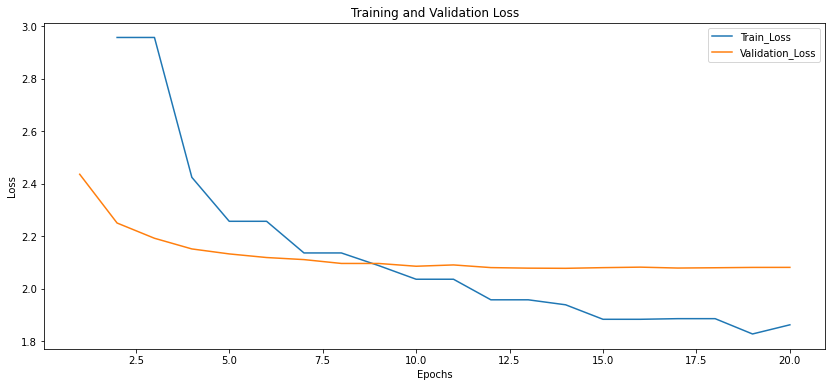

In [12]:
plt.figure(figsize=(14,6))
history['Train_Loss'].plot(legend=True)
history['Validation_Loss'].plot(legend=True)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
# load model
model = AutoModelForSeq2SeqLM.from_pretrained("results\checkpoint-6000")
tokenizer = AutoTokenizer.from_pretrained("t5-small", model_max_length=2000)

In [56]:
document = """WASHINGTON (Reuters) - White House spokesman Sean Spicer on Monday defended his statement that President Donald Trump’s inauguration was the most-watched ever, citing viewership on television and other media and insisting that “our intention is never to lie to you.” “I believe that we have to be honest with the American people. I think sometimes we can disagree with the facts,” Spicer told a news briefing. “I’m going to come out here and tell you the facts as I know them. And if we make a mistake, we’ll do our best to correct it,” he added. Spicer had been sharply criticized for his comments on Saturday by media, which noted photographs from former President Barack Obama’s first inauguration showed much larger crowds than Trump drew on Friday."""
human_summary = """White House defends statement on audience for Trump's inaugural"""

In [57]:
# function to get summary for any document
def predict_summary(document):
  device = model.device
  tokenized = tokenizer([document], truncation =True, padding ='longest',return_tensors='pt')
  tokenized_dictionary = {k: v.to(device) for k, v in tokenized.items()}
  tokenized_result = model.generate(**tokenized_dictionary, max_length=128)
  tokenized_result = tokenized_result.to('cpu')
  predicted_summary = tokenizer.decode(tokenized_result[0])
  return predicted_summary

In [58]:
human_summary

"White House defends statement on audience for Trump's inaugural"

In [59]:
pred_summary = predict_summary(document)
pred_summary

'<pad> White House spokesman defends Trump inauguration statement</s>'

In [60]:
# function to get rouge scores
def get_rouge_scores(actual_summary, predicted_summary):
    actual_summary = " ".join(simple_preprocess(actual_summary))
    predicted_summary = " ".join(simple_preprocess(predicted_summary))
    rouge = Rouge()
    scores = rouge.get_scores(predicted_summary, actual_summary)
    return [scores[0]['rouge-1']['f'], scores[0]['rouge-2']['f'], scores[0]['rouge-l']['f']]

In [93]:
# function to get f1 score
def calculate_f1_score(machine_summary, reference_summary):

    reference_summary = " ".join(simple_preprocess(reference_summary))
    machine_summary = " ".join(simple_preprocess(machine_summary))

    # Tokenize the summaries into words
    machine_tokens = set(word_tokenize(machine_summary.lower()))
    reference_tokens = set(word_tokenize(reference_summary.lower()))

    

    # Calculate precision and recall

    try:
        precision = len(machine_tokens.intersection(reference_tokens)) / len(machine_tokens)
    except ZeroDivisionError:
        precision = 0
    try:
        recall = len(machine_tokens.intersection(reference_tokens)) / len(reference_tokens)
    except ZeroDivisionError:
        recall = 0

    # Calculate F1 score
    try:
        f1_score = 2 * ((precision * recall) / (precision + recall))
    except ZeroDivisionError:
        f1_score = 0
    
    return f1_score

In [85]:
# function to get bleu score
def calculate_bleu_score(machine_summary, reference_summary):
    reference_summary = simple_preprocess(reference_summary)
    machine_summary = simple_preprocess(machine_summary)
    return bleu_score.sentence_bleu([reference_summary], machine_summary)

In [87]:
# load the test data
test_data = pd.read_csv('news_test_data.csv')
test_data.head()

,news,summary
0,DAKAR (Reuters) - A once-fringe separatist mov...,State crackdown fuels independence push in Ang...
1,BEIJING (Reuters) - A Donald Trump presidency ...,Trump will pursue 'regional hegemony' in South...
2,"WASHINGTON (Reuters) - Elon Musk, the chairman...","Uber, SpaceX/Tesla, and PepsiCo execs join Tru..."
3,WASHINGTON (Reuters) - Democratic U.S. Senator...,Democratic senator opposes spending bill over ...
4,BEIJING (Reuters) - The United States said on ...,"U.S. directly communicating with North Korea, ..."


In [88]:
# Evaluate testing data using seq2seq model

rouge1_scores = []
rouge2_scores = []
rougel_scores = []
f1_scores = []
bleu_scores = []


for i in tqdm(range(len(test_data))):

  doc = test_data.loc[i]['news']
  pred_summary = predict_summary(doc)
  human_summary = test_data.loc[i]['summary']

  score = get_rouge_scores(human_summary, pred_summary)
  f1 = calculate_f1_score(pred_summary, human_summary)
  bleu = calculate_bleu_score(pred_summary, human_summary)

  rouge1_scores.append(score[0])
  rouge2_scores.append(score[1])
  rougel_scores.append(score[2])
  f1_scores.append(f1)
  bleu_scores.append(bleu)

test_data['s2s_rouge1'] = rouge1_scores
test_data['s2s_rouge2'] = rouge2_scores
test_data['s2s_rougel'] = rougel_scores
test_data['s2s_f1'] = f1_scores
test_data['s2s_bleu'] = bleu_scores

test_data

100%|██████████| 100/100 [00:35<00:00,  2.78it/s]


,news,summary,s2s_rouge1,s2s_rouge2,s2s_rougel,s2s_f1,s2s_bleu
0,DAKAR (Reuters) - A once-fringe separatist mov...,State crackdown fuels independence push in Ang...,0.210526,0.000000,0.105263,0.210526,1.189646e-231
1,BEIJING (Reuters) - A Donald Trump presidency ...,Trump will pursue 'regional hegemony' in South...,0.434783,0.181818,0.434783,0.434783,3.374479e-78
2,"WASHINGTON (Reuters) - Elon Musk, the chairman...","Uber, SpaceX/Tesla, and PepsiCo execs join Tru...",0.421053,0.117647,0.421053,0.421053,6.480360e-155
3,WASHINGTON (Reuters) - Democratic U.S. Senator...,Democratic senator opposes spending bill over ...,0.190476,0.100000,0.190476,0.190476,3.904602e-155
4,BEIJING (Reuters) - The United States said on ...,"U.S. directly communicating with North Korea, ...",0.625000,0.571429,0.625000,0.625000,4.463236e-01
...,...,...,...,...,...,...,...
95,"DAYTON, Ohio (Reuters) - Secret Service office...",New disturbance at Trump rally as crucial Repu...,0.210526,0.000000,0.210526,0.210526,1.119310e-231
96,ROME/PALERMO (Reuters) - The death of Sicilian...,"The boss is dead but the mafia lives, magistra...",0.173913,0.000000,0.086957,0.173913,1.164047e-231
97,PRISTINA (Reuters) - Kosovo s government consi...,Kosovo at risk of attacks by returning Islamis...,0.260870,0.000000,0.260870,0.260870,1.239529e-231
98,"DIYARBAKIR, Turkey (Reuters) - Turkish securit...","Turkish troops, Kurdish militants clash near I...",0.380952,0.105263,0.380952,0.380952,6.513869e-155


In [89]:
# results_df to append rouge scores
results_df = pd.DataFrame(columns=['Model', 'Rouge 1', 'Rouge 2', 'Rouge L', 'F1 Score', 'Bleu Score'])

In [90]:
# append average rouge scores of testing data using Seq2Seq model
results_df.loc[len(results_df)] = ['Seq2Seq Model (t5-small)', test_data['s2s_rouge1'].mean(), test_data['s2s_rouge2'].mean(), test_data['s2s_rougel'].mean(), test_data['s2s_f1'].mean(), test_data['s2s_bleu'].mean()]
results_df

,Model,Rouge 1,Rouge 2,Rouge L,F1 Score,Bleu Score
0,Seq2Seq Model (t5-small),0.397748,0.169955,0.369123,0.397748,0.068169


Latent Semantic Analysis (LSA) Method

Reference: Deerwester, S., Dumais, S. T., Landauer, T. K., Furnas, G. W., & Harshman, R. A. (1990). Indexing by latent semantic analysis. Journal of the American society for information science, 41(6), 391-407.

In [50]:
# function to get lsa summarized text
def lsa_summarize(text):

    # max words
    max_words = 15

    # Set the number of sentences to keep in the summary
    num_sentences = 1

    # Create a parser object
    parser = PlaintextParser.from_string(text, Tokenizer("english"))

    # Create an LSA summarizer object
    lsa_summarizer = LsaSummarizer()

    # Get the summary using LSA
    lsa_summary = lsa_summarizer(parser.document, num_sentences)

    # preprocess the summary
    summary_words = simple_preprocess(" ".join(lsa_summary[0].words))
    lsa_summary = " ".join(summary_words[:max_words])

    return lsa_summary

In [51]:
lsa_summarize(document)

'think sometimes we can disagree with the facts spicer told news briefing'

In [94]:
# Evaluate testing data using LSA method

rouge1_scores = []
rouge2_scores = []
rougel_scores = []
f1_scores = []
bleu_scores = []


for i in tqdm(range(len(test_data))):

  doc = test_data.loc[i]['news']
  pred_summary = lsa_summarize(doc)
  human_summary = test_data.loc[i]['summary']

  score = get_rouge_scores(human_summary, pred_summary)
  f1 = calculate_f1_score(pred_summary, human_summary)
  bleu = calculate_bleu_score(pred_summary, human_summary)

  rouge1_scores.append(score[0])
  rouge2_scores.append(score[1])
  rougel_scores.append(score[2])
  f1_scores.append(f1)
  bleu_scores.append(bleu)

test_data['lsa_rouge1'] = rouge1_scores
test_data['lsa_rouge2'] = rouge2_scores
test_data['lsa_rougel'] = rougel_scores
test_data['lsa_f1'] = f1_scores
test_data['lsa_bleu'] = bleu_scores

test_data

100%|██████████| 100/100 [00:00<00:00, 125.50it/s]


,news,summary,s2s_rouge1,s2s_rouge2,s2s_rougel,s2s_f1,s2s_bleu,lsa_rouge1,lsa_rouge2,lsa_rougel,lsa_f1,lsa_bleu
0,DAKAR (Reuters) - A once-fringe separatist mov...,State crackdown fuels independence push in Ang...,0.210526,0.000000,0.105263,0.210526,1.189646e-231,0.086957,0.0,0.086957,0.086957,9.257325e-232
1,BEIJING (Reuters) - A Donald Trump presidency ...,Trump will pursue 'regional hegemony' in South...,0.434783,0.181818,0.434783,0.434783,3.374479e-78,0.076923,0.0,0.076923,0.076923,9.257325e-232
2,"WASHINGTON (Reuters) - Elon Musk, the chairman...","Uber, SpaceX/Tesla, and PepsiCo execs join Tru...",0.421053,0.117647,0.421053,0.421053,6.480360e-155,0.080000,0.0,0.080000,0.080000,9.257325e-232
3,WASHINGTON (Reuters) - Democratic U.S. Senator...,Democratic senator opposes spending bill over ...,0.190476,0.100000,0.190476,0.190476,3.904602e-155,0.142857,0.0,0.142857,0.142857,1.100888e-231
4,BEIJING (Reuters) - The United States said on ...,"U.S. directly communicating with North Korea, ...",0.625000,0.571429,0.625000,0.625000,4.463236e-01,0.000000,0.0,0.000000,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"DAYTON, Ohio (Reuters) - Secret Service office...",New disturbance at Trump rally as crucial Repu...,0.210526,0.000000,0.210526,0.210526,1.119310e-231,0.080000,0.0,0.080000,0.080000,9.257325e-232
96,ROME/PALERMO (Reuters) - The death of Sicilian...,"The boss is dead but the mafia lives, magistra...",0.173913,0.000000,0.086957,0.173913,1.164047e-231,0.076923,0.0,0.076923,0.076923,9.257325e-232
97,PRISTINA (Reuters) - Kosovo s government consi...,Kosovo at risk of attacks by returning Islamis...,0.260870,0.000000,0.260870,0.260870,1.239529e-231,0.160000,0.0,0.080000,0.160000,1.100888e-231
98,"DIYARBAKIR, Turkey (Reuters) - Turkish securit...","Turkish troops, Kurdish militants clash near I...",0.380952,0.105263,0.380952,0.380952,6.513869e-155,0.000000,0.0,0.000000,0.000000,0.000000e+00


In [95]:
# append average rouge scores of testing data using Seq2Seq model
results_df.loc[len(results_df)] = ['LSA Method', test_data['lsa_rouge1'].mean(), test_data['lsa_rouge2'].mean(), test_data['lsa_rougel'].mean(), test_data['lsa_f1'].mean(), test_data['lsa_bleu'].mean()]
results_df

,Model,Rouge 1,Rouge 2,Rouge L,F1 Score,Bleu Score
0,Seq2Seq Model (t5-small),0.397748,0.169955,0.369123,0.397748,0.068169
1,LSA Method,0.139205,0.024156,0.119086,0.139205,0.002767


TextRank Method

Reference: Mihalcea, R., & Tarau, P. (2004). TextRank: Bringing order into text. In Proceedings of the 2004 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 404-411).

In [48]:
# function to get text rank summarized text
def text_rank_summarize(text):

    # max words
    max_words = 15
    
    # Set the number of sentences to keep in the summary
    num_sentences = 1

    # Create a parser object
    parser = PlaintextParser.from_string(document, Tokenizer("english"))

    # Create a TextRank summarizer object
    textrank_summarizer = TextRankSummarizer()

    # Get the summary using TextRank
    textrank_summary = textrank_summarizer(parser.document, num_sentences)

    # preprocess the summary
    summary_words = simple_preprocess(" ".join(textrank_summary[0].words))
    textrank_summary = " ".join(summary_words[:max_words])

    return textrank_summary

In [49]:
text_rank_summarize(document)

'washington reuters white house spokesman sean spicer on monday defended his statement that president donald'

In [96]:
# Evaluate testing data using Text Rank method

rouge1_scores = []
rouge2_scores = []
rougel_scores = []
f1_scores = []
bleu_scores = []


for i in tqdm(range(len(test_data))):

  doc = test_data.loc[i]['news']
  pred_summary = text_rank_summarize(doc)
  human_summary = test_data.loc[i]['summary']

  score = get_rouge_scores(human_summary, pred_summary)
  f1 = calculate_f1_score(pred_summary, human_summary)
  bleu = calculate_bleu_score(pred_summary, human_summary)

  rouge1_scores.append(score[0])
  rouge2_scores.append(score[1])
  rougel_scores.append(score[2])
  f1_scores.append(f1)
  bleu_scores.append(bleu)

test_data['tr_rouge1'] = rouge1_scores
test_data['tr_rouge2'] = rouge2_scores
test_data['tr_rougel'] = rougel_scores
test_data['tr_f1'] = f1_scores
test_data['tr_bleu'] = bleu_scores

test_data

100%|██████████| 100/100 [00:00<00:00, 350.19it/s]


,news,summary,s2s_rouge1,s2s_rouge2,s2s_rougel,s2s_f1,s2s_bleu,lsa_rouge1,lsa_rouge2,lsa_rougel,lsa_f1,lsa_bleu,tr_rouge1,tr_rouge2,tr_rougel,tr_f1,tr_bleu
0,DAKAR (Reuters) - A once-fringe separatist mov...,State crackdown fuels independence push in Ang...,0.210526,0.000000,0.105263,0.210526,1.189646e-231,0.086957,0.0,0.086957,0.086957,9.257325e-232,0.0,0.0,0.0,0.0,0.0
1,BEIJING (Reuters) - A Donald Trump presidency ...,Trump will pursue 'regional hegemony' in South...,0.434783,0.181818,0.434783,0.434783,3.374479e-78,0.076923,0.0,0.076923,0.076923,9.257325e-232,0.0,0.0,0.0,0.0,0.0
2,"WASHINGTON (Reuters) - Elon Musk, the chairman...","Uber, SpaceX/Tesla, and PepsiCo execs join Tru...",0.421053,0.117647,0.421053,0.421053,6.480360e-155,0.080000,0.0,0.080000,0.080000,9.257325e-232,0.0,0.0,0.0,0.0,0.0
3,WASHINGTON (Reuters) - Democratic U.S. Senator...,Democratic senator opposes spending bill over ...,0.190476,0.100000,0.190476,0.190476,3.904602e-155,0.142857,0.0,0.142857,0.142857,1.100888e-231,0.0,0.0,0.0,0.0,0.0
4,BEIJING (Reuters) - The United States said on ...,"U.S. directly communicating with North Korea, ...",0.625000,0.571429,0.625000,0.625000,4.463236e-01,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"DAYTON, Ohio (Reuters) - Secret Service office...",New disturbance at Trump rally as crucial Repu...,0.210526,0.000000,0.210526,0.210526,1.119310e-231,0.080000,0.0,0.080000,0.080000,9.257325e-232,0.0,0.0,0.0,0.0,0.0
96,ROME/PALERMO (Reuters) - The death of Sicilian...,"The boss is dead but the mafia lives, magistra...",0.173913,0.000000,0.086957,0.173913,1.164047e-231,0.076923,0.0,0.076923,0.076923,9.257325e-232,0.0,0.0,0.0,0.0,0.0
97,PRISTINA (Reuters) - Kosovo s government consi...,Kosovo at risk of attacks by returning Islamis...,0.260870,0.000000,0.260870,0.260870,1.239529e-231,0.160000,0.0,0.080000,0.160000,1.100888e-231,0.0,0.0,0.0,0.0,0.0
98,"DIYARBAKIR, Turkey (Reuters) - Turkish securit...","Turkish troops, Kurdish militants clash near I...",0.380952,0.105263,0.380952,0.380952,6.513869e-155,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0


In [97]:
# append average rouge scores of testing data using Seq2Seq model
results_df.loc[len(results_df)] = ['TextRank Method', test_data['tr_rouge1'].mean(), test_data['tr_rouge2'].mean(), test_data['tr_rougel'].mean(), test_data['tr_f1'].mean(), test_data['tr_bleu'].mean()]
results_df

,Model,Rouge 1,Rouge 2,Rouge L,F1 Score,Bleu Score
0,Seq2Seq Model (t5-small),0.397748,0.169955,0.369123,0.397748,6.816941e-02
1,LSA Method,0.139205,0.024156,0.119086,0.139205,2.766874e-03
2,TextRank Method,0.017672,0.003308,0.017672,0.017672,1.863953e-156


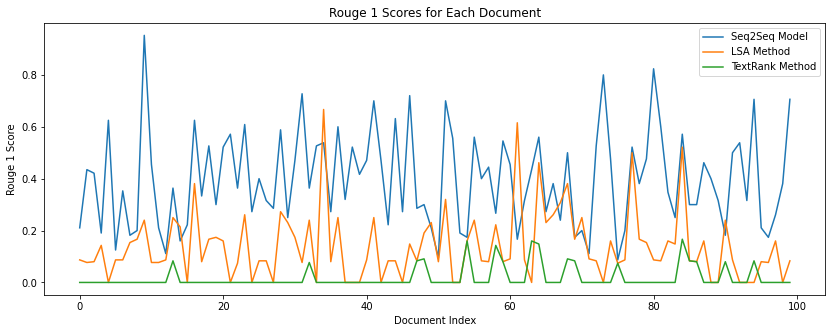

In [99]:
# plot the rouge 1 scores for each document for each method
plt.figure(figsize=(14, 5))
plt.plot(test_data['s2s_rouge1'], label='Seq2Seq Model')
plt.plot(test_data['lsa_rouge1'], label='LSA Method')
plt.plot(test_data['tr_rouge1'], label='TextRank Method')
plt.legend()
plt.title('Rouge 1 Scores for Each Document')
plt.xlabel('Document Index')
plt.ylabel('Rouge 1 Score')
plt.show()

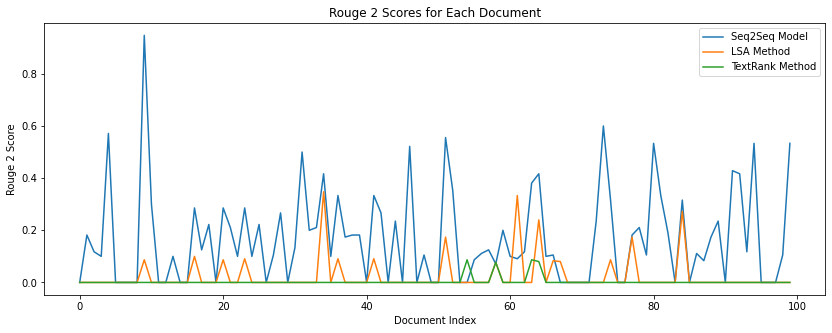

In [100]:
# plot the rouge 2 scores for each document for each method
plt.figure(figsize=(14, 5))
plt.plot(test_data['s2s_rouge2'], label='Seq2Seq Model')
plt.plot(test_data['lsa_rouge2'], label='LSA Method')
plt.plot(test_data['tr_rouge2'], label='TextRank Method')
plt.legend()
plt.title('Rouge 2 Scores for Each Document')
plt.xlabel('Document Index')
plt.ylabel('Rouge 2 Score')
plt.show()

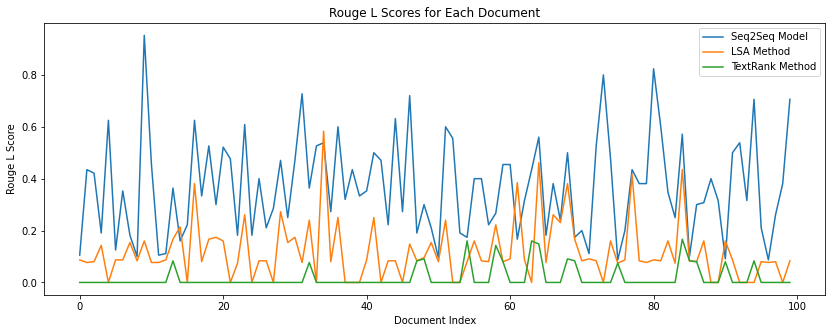

In [101]:
# plot the rouge L scores for each document for each method
plt.figure(figsize=(14, 5))
plt.plot(test_data['s2s_rougel'], label='Seq2Seq Model')
plt.plot(test_data['lsa_rougel'], label='LSA Method')
plt.plot(test_data['tr_rougel'], label='TextRank Method')
plt.legend()
plt.title('Rouge L Scores for Each Document')
plt.xlabel('Document Index')
plt.ylabel('Rouge L Score')
plt.show()

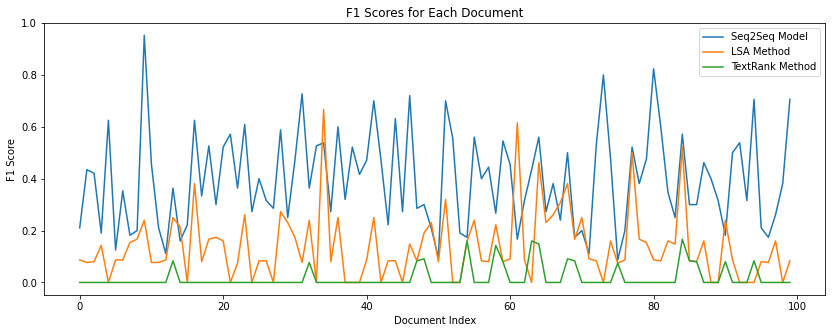

In [102]:
# plot the f1 scores for each document for each method
plt.figure(figsize=(14, 5))
plt.plot(test_data['s2s_f1'], label='Seq2Seq Model')
plt.plot(test_data['lsa_f1'], label='LSA Method')
plt.plot(test_data['tr_f1'], label='TextRank Method')
plt.legend()
plt.title('F1 Scores for Each Document')
plt.xlabel('Document Index')
plt.ylabel('F1 Score')
plt.show()

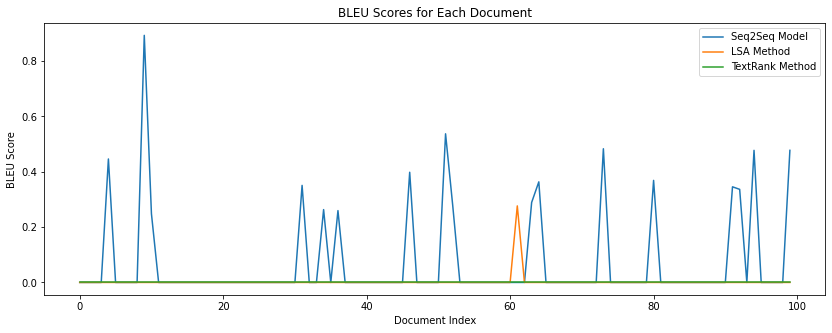

In [103]:
# plot the bleu scores for each document for each method
plt.figure(figsize=(14, 5))
plt.plot(test_data['s2s_bleu'], label='Seq2Seq Model')
plt.plot(test_data['lsa_bleu'], label='LSA Method')
plt.plot(test_data['tr_bleu'], label='TextRank Method')
plt.legend()
plt.title('BLEU Scores for Each Document')
plt.xlabel('Document Index')
plt.ylabel('BLEU Score')
plt.show()

In [ ]:
# set the index of the results dataframe to the model name
results_df.set_index('Model', inplace=True)

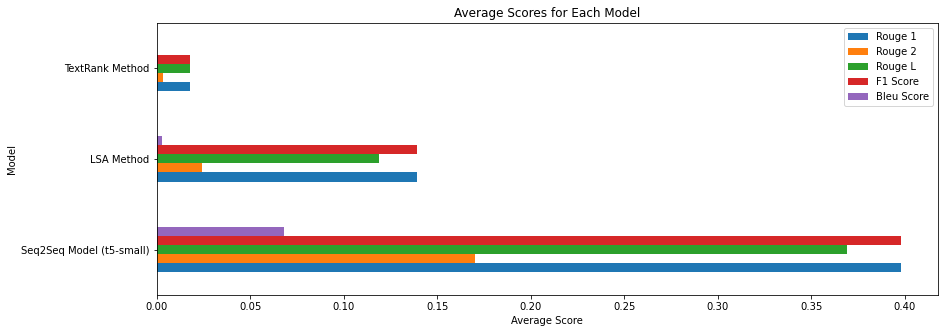

In [112]:
# horizontal bar plot of results
results_df.plot(kind='barh', figsize=(14, 5))
plt.title('Average Scores for Each Model')
plt.xlabel('Average Score')
plt.ylabel('Model')
plt.show()

We see our transformers based Seq2Seq model outperforms the LSA and TextRank methods. This is because the transformers model is able to learn the context of the text and generate a summary that is more coherent and meaningful. We will thus proceed to use this model for our dashboard.